In [1]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.9 MB/s eta 0:00:00


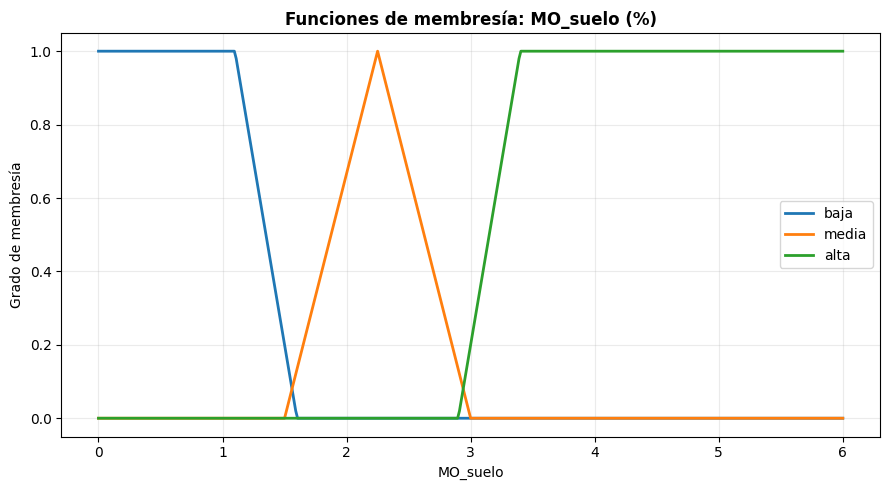

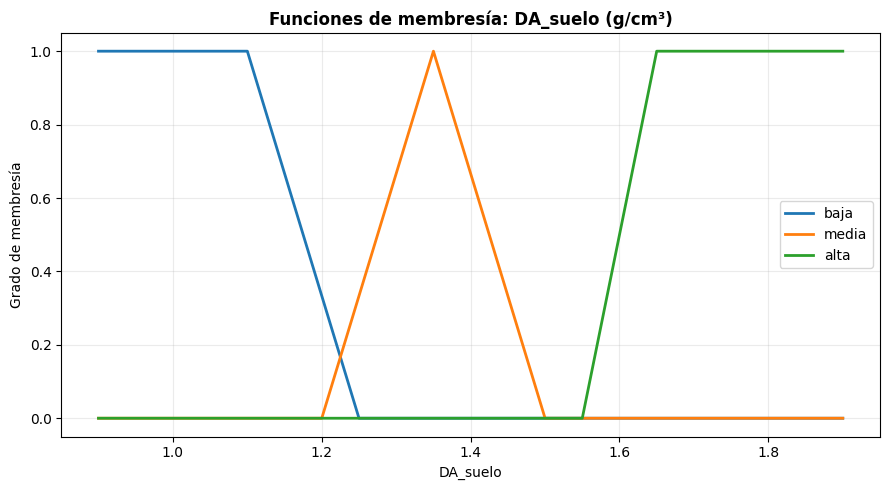

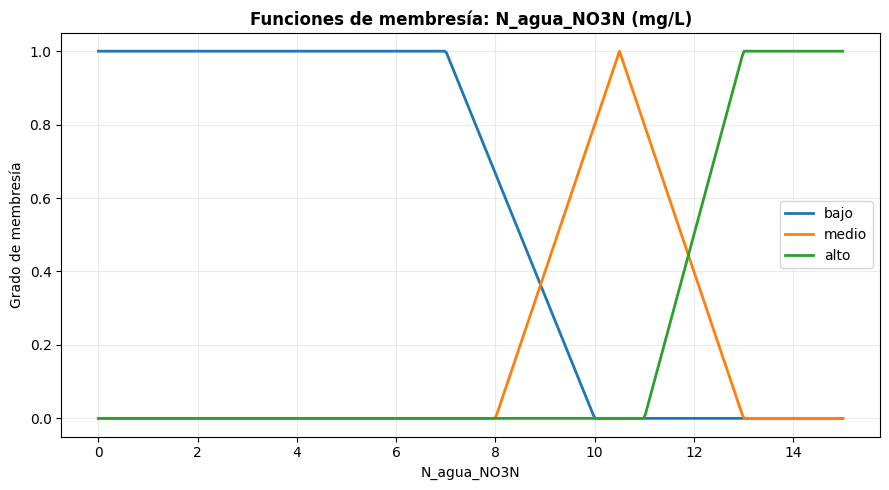

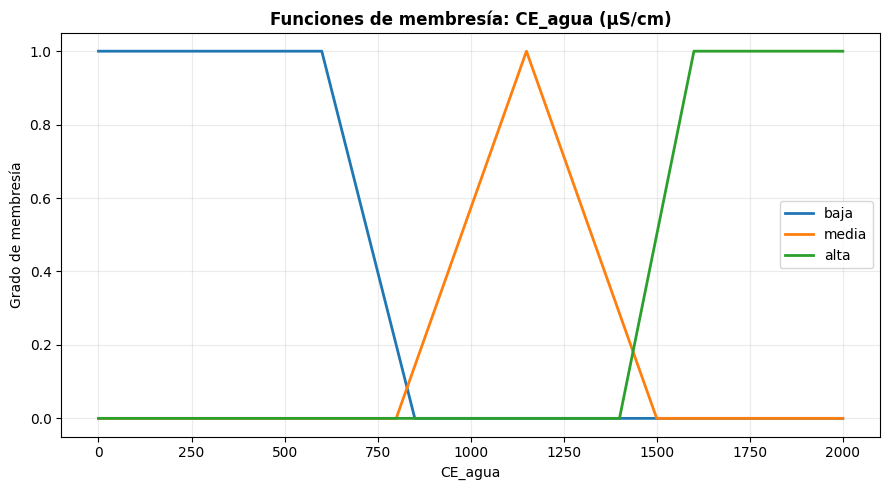

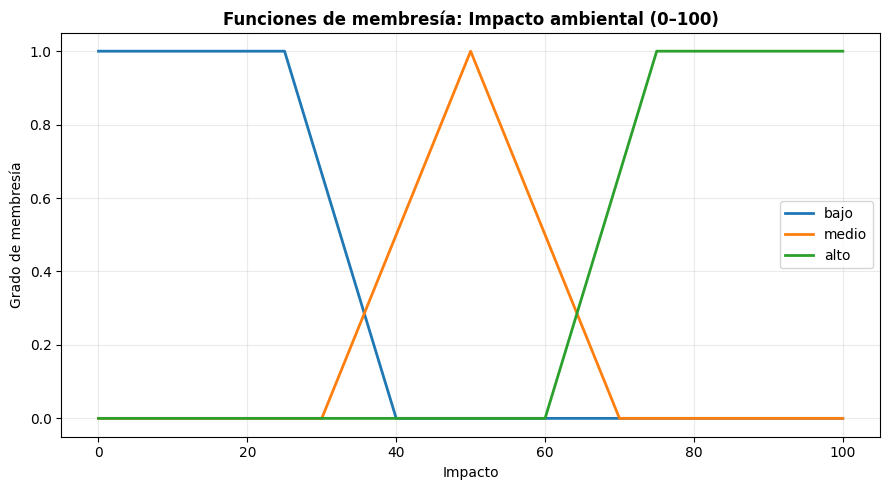

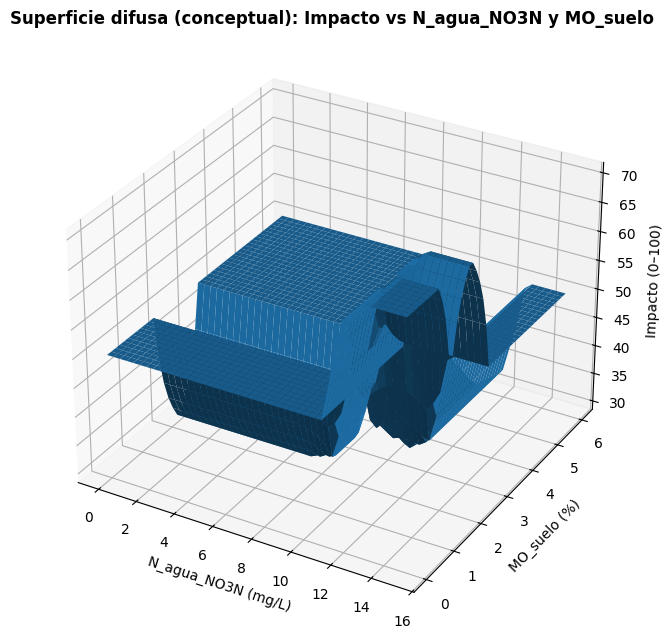

Registros usados: 54
count    54.000000
mean     30.141219
std       2.564489
min      29.119271
25%      29.119271
50%      29.119271
75%      29.119271
max      38.923409
Name: Impacto_fuzzy, dtype: float64
Riesgo_fuzzy
Bajo    54
Name: count, dtype: int64


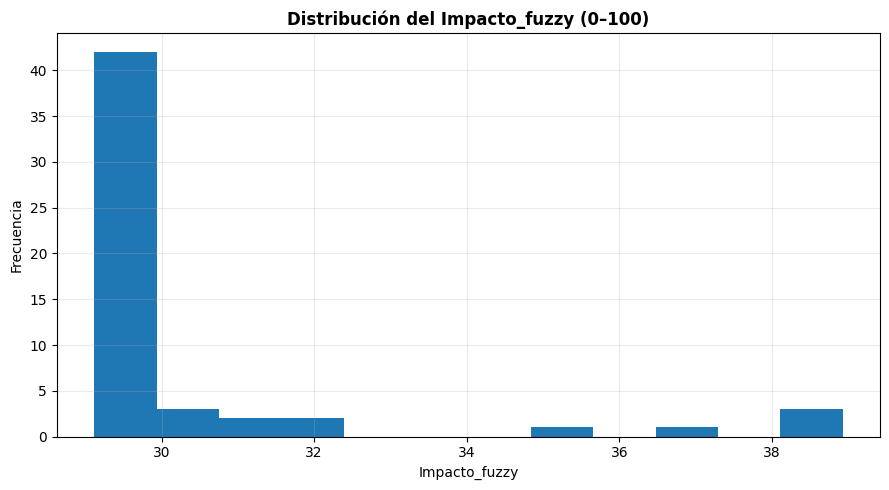

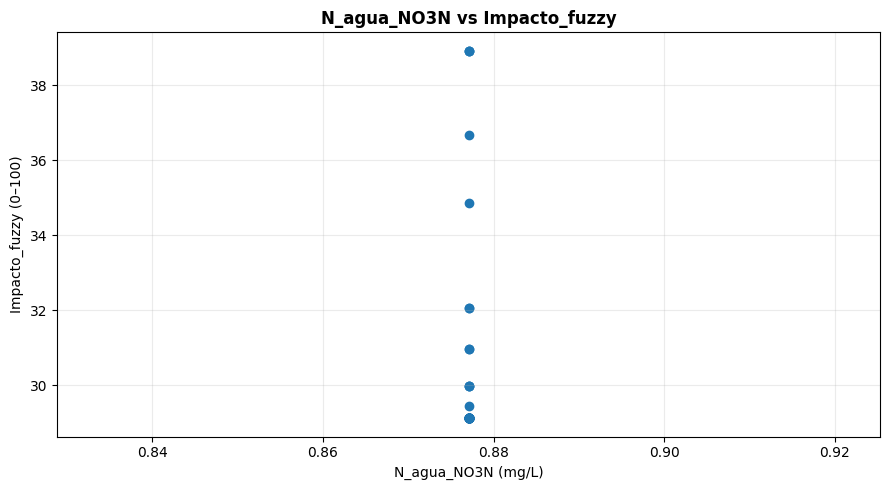

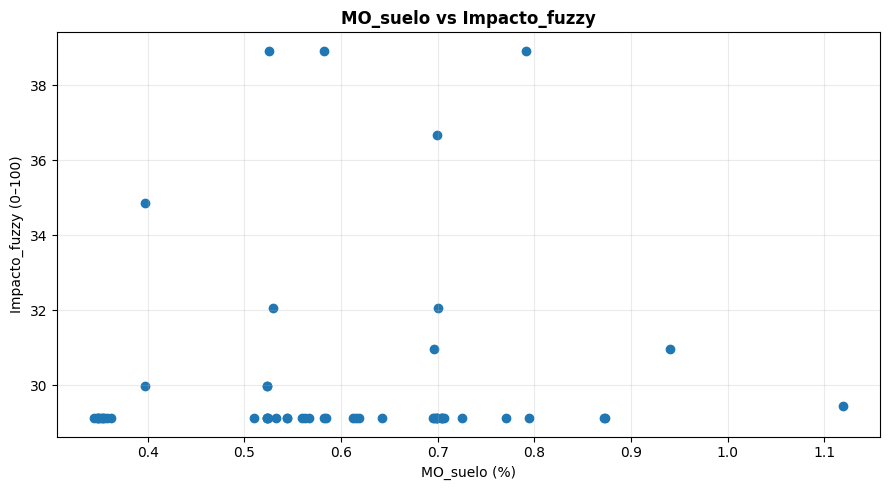

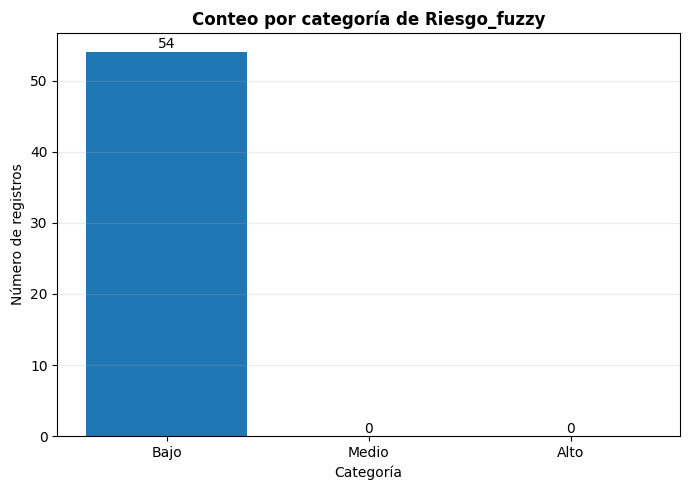

✅ Exportados: resultados_fuzzy_usco_completos.csv y top10_criticos_usco.csv


In [6]:
# ============================================================
# ANEXO B — Sistema de inferencia difusa (Mamdani) para riesgo de lixiviación
# (Versión robusta: columnas auto-detect + gráficas + export)
# ============================================================
# Requisitos:
#   pip install numpy pandas matplotlib scikit-fuzzy
# ============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# -----------------------------
# Helpers de robustez
# -----------------------------
def _slug(s: str) -> str:
    """Normaliza un nombre de columna: minúsculas, sin tildes, espacios a '_'."""
    s = s.strip().lower()
    s = s.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u").replace("ñ","n")
    s = s.replace("%", "pct")
    s = re.sub(r"[(){}\[\]]", "", s)
    s = s.replace("/", "_")
    s = re.sub(r"[^a-z0-9._\s-]", "", s)
    s = re.sub(r"[\s-]+", "_", s)
    return s.strip("_")

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df = df.loc[:, ~df.columns.str.contains("^Unnamed", na=False)]
    mapping = {c: _slug(c) for c in df.columns}
    return df.rename(columns=mapping)

def pick_column(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(
        f"No encontré ninguna columna entre: {candidates}.\n"
        f"Columnas disponibles: {df.columns.tolist()}"
    )

def ensure_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def savefig(name: str, dpi: int = 300):
    plt.savefig(name, dpi=dpi, bbox_inches="tight")

def fix_github_raw(url: str) -> str:
    """
    Convierte URLs tipo:
      .../refs/heads/main/...  -> .../main/...
    porque pandas a veces tiene problemas con refs/heads.
    """
    return url.replace("/refs/heads/", "/")

# ------------------------------------------------------------
# B.1) DEFINICIÓN DEL SISTEMA DIFUSO (GENÉRICO)
# ------------------------------------------------------------

# Universos
N_min, N_max = 0, 15          # mg/L NO3–N
MO_min, MO_max = 0, 6         # %
DA_min, DA_max = 0.9, 1.9     # g/cm3
CE_min, CE_max = 0, 2000      # µS/cm
I_min, I_max = 0, 100         # índice 0–100

# Variables difusas
N  = ctrl.Antecedent(np.linspace(N_min,  N_max,  401), 'N_agua_NO3N')
MO = ctrl.Antecedent(np.linspace(MO_min, MO_max, 401), 'MO_suelo')
DA = ctrl.Antecedent(np.linspace(DA_min, DA_max, 401), 'DA_suelo')
CE = ctrl.Antecedent(np.linspace(CE_min, CE_max, 401), 'CE_agua')
Impacto = ctrl.Consequent(np.linspace(I_min, I_max, 401), 'Impacto')

# Membresías
MO['baja']  = fuzz.trapmf(MO.universe, [0, 0, 1.10, 1.60])
MO['media'] = fuzz.trimf(MO.universe, [1.50, 2.25, 3.00])
MO['alta']  = fuzz.trapmf(MO.universe, [2.90, 3.40, 6.00, 6.00])

N['bajo']  = fuzz.trapmf(N.universe, [0, 0, 7.0, 10.0])
N['medio'] = fuzz.trimf(N.universe, [8.0, 10.5, 13.0])
N['alto']  = fuzz.trapmf(N.universe, [11.0, 13.0, 15.0, 15.0])

DA['baja']  = fuzz.trapmf(DA.universe, [DA_min, DA_min, 1.10, 1.25])
DA['media'] = fuzz.trimf(DA.universe, [1.20, 1.35, 1.50])
DA['alta']  = fuzz.trapmf(DA.universe, [1.55, 1.65, DA_max, DA_max])

CE['baja']  = fuzz.trapmf(CE.universe, [0, 0, 600, 850])
CE['media'] = fuzz.trimf(CE.universe, [800, 1150, 1500])
CE['alta']  = fuzz.trapmf(CE.universe, [1400, 1600, 2000, 2000])

Impacto['bajo']  = fuzz.trapmf(Impacto.universe, [0, 0, 25, 40])
Impacto['medio'] = fuzz.trimf(Impacto.universe, [30, 50, 70])
Impacto['alto']  = fuzz.trapmf(Impacto.universe, [60, 75, 100, 100])

# Reglas
rules = [
    # N alto
    ctrl.Rule(N['alto'] & MO['baja'] & DA['baja'],  Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['baja'] & DA['media'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['baja'] & DA['alta'],  Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['media'] & DA['baja'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['media'] & DA['media'],Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['media'] & DA['alta'], Impacto['medio']),
    ctrl.Rule(N['alto'] & MO['alta'] & DA['baja'],  Impacto['medio']),
    ctrl.Rule(N['alto'] & MO['alta'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['alto'] & MO['alta'] & DA['alta'],  Impacto['medio']),

    # N medio
    ctrl.Rule(N['medio'] & MO['baja'] & DA['baja'],  Impacto['alto']),
    ctrl.Rule(N['medio'] & MO['baja'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['baja'] & DA['alta'],  Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['media'] & DA['baja'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['media'] & DA['media'],Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['media'] & DA['alta'], Impacto['bajo']),
    ctrl.Rule(N['medio'] & MO['alta'] & DA['baja'],  Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['alta'] & DA['media'], Impacto['bajo']),
    ctrl.Rule(N['medio'] & MO['alta'] & DA['alta'],  Impacto['bajo']),

    # N bajo
    ctrl.Rule(N['bajo'] & MO['baja'] & DA['baja'],  Impacto['medio']),
    ctrl.Rule(N['bajo'] & MO['baja'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['bajo'] & MO['baja'] & DA['alta'],  Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['media'] & DA['baja'], Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['media'] & DA['media'],Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['media'] & DA['alta'], Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['alta'] & DA['alta'],  Impacto['bajo']),

    # Modulación por CE alta
    ctrl.Rule(CE['alta'] & N['alto'], Impacto['alto']),
    ctrl.Rule(CE['alta'] & N['medio'] & MO['baja'], Impacto['alto']),
    ctrl.Rule(CE['alta'] & N['medio'] & MO['media'], Impacto['medio']),
    ctrl.Rule(CE['alta'] & N['bajo'] & MO['baja'], Impacto['medio']),

    # Cobertura
    ctrl.Rule(N['bajo'] | N['medio'] | N['alto'], Impacto['medio']),
]

system = ctrl.ControlSystem(rules)

def fuzzy_impact(n, mo, da, ce):
    sim = ctrl.ControlSystemSimulation(system)
    sim.input["N_agua_NO3N"] = float(n)
    sim.input["MO_suelo"] = float(mo)
    sim.input["DA_suelo"] = float(da)
    sim.input["CE_agua"] = float(ce)
    sim.compute()
    return float(sim.output["Impacto"])

# ------------------------------------------------------------
# Figuras: membresías + superficie conceptual
# ------------------------------------------------------------
def plot_memberships(save_png=True):
    def _plot(var, title, fname):
        plt.figure(figsize=(9, 5))
        for term_name, mf in var.terms.items():
            plt.plot(var.universe, mf.mf, label=term_name, linewidth=2)
        plt.title(title, weight="bold")
        plt.xlabel(var.label)
        plt.ylabel("Grado de membresía")
        plt.grid(alpha=0.25)
        plt.legend()
        plt.tight_layout()
        if save_png:
            savefig(fname)
        plt.show()

    _plot(MO, "Funciones de membresía: MO_suelo (%)", "fig_mf_MO_suelo.png")
    _plot(DA, "Funciones de membresía: DA_suelo (g/cm³)", "fig_mf_DA_suelo.png")
    _plot(N,  "Funciones de membresía: N_agua_NO3N (mg/L)", "fig_mf_N_agua_NO3N.png")
    _plot(CE, "Funciones de membresía: CE_agua (µS/cm)", "fig_mf_CE_agua.png")
    _plot(Impacto, "Funciones de membresía: Impacto ambiental (0–100)", "fig_mf_Impacto.png")

def plot_surface_N_MO(da_const=1.35, ce_const=900, n_points=45, save_png=True):
    Ns = np.linspace(N_min, N_max, n_points)
    MOs = np.linspace(MO_min, MO_max, n_points)
    Z = np.zeros((n_points, n_points))

    for i, n in enumerate(Ns):
        for j, mo in enumerate(MOs):
            Z[j, i] = fuzzy_impact(n=n, mo=mo, da=da_const, ce=ce_const)

    Xg, Yg = np.meshgrid(Ns, MOs)

    fig = plt.figure(figsize=(10, 6.5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Xg, Yg, Z, linewidth=0, antialiased=True)
    ax.set_title("Superficie difusa (conceptual): Impacto vs N_agua_NO3N y MO_suelo", weight="bold")
    ax.set_xlabel("N_agua_NO3N (mg/L)")
    ax.set_ylabel("MO_suelo (%)")
    ax.set_zlabel("Impacto (0–100)")
    plt.tight_layout()
    if save_png:
        savefig("fig_superficie_fuzzy_NO3N_MO.png")
    plt.show()

# ------------------------------------------------------------
# B.2) Aplicación a datos USCO (CSV)
# ------------------------------------------------------------
def run_usco_dataset(url_csv: str) -> pd.DataFrame:
    url_csv = fix_github_raw(url_csv)

    df_raw = pd.read_csv(url_csv, encoding="utf-8-sig")
    df = normalize_columns(df_raw)

    # Auto-detección para TU CSV (y variantes comunes)
    col_mo = pick_column(df, ["m.o_pct", "mo_pct", "mo", "materia_organica", "materia_organica_pct"])
    col_da = pick_column(df, ["d.a", "da", "densidad_aparente", "densidad_aparente_gcm3"])
    col_n  = pick_column(df, ["nitrogeno_agua_mg_l", "nitrogeno_agua_mgl", "n_agua_mg_l", "no3n_mg_l", "nitratos_agua"])
    col_ce = pick_column(df, [
        "ce_agua_ds_m", "ce_agua_dsm",
        "ce_agua_ds_cm",          # por si quedó rotulado raro
        "ce_agua", "conductividad_electrica_agua_ds_m"
    ])

    df = ensure_numeric(df, [col_mo, col_da, col_n, col_ce])

    work = df.copy()
    work["MO_suelo"] = work[col_mo]
    work["DA_suelo"] = work[col_da]
    work["N_agua_NO3N"] = work[col_n]

    # CE: en tu caso valores ~0.1 => dS/m, convertir a µS/cm (x1000)
    work["CE_agua"] = work[col_ce] * 1000.0

    work = work.dropna(subset=["MO_suelo", "DA_suelo", "N_agua_NO3N", "CE_agua"]).reset_index(drop=True)

    work["Impacto_fuzzy"] = work.apply(
        lambda r: fuzzy_impact(r["N_agua_NO3N"], r["MO_suelo"], r["DA_suelo"], r["CE_agua"]),
        axis=1
    )

    def clasificar(x):
        if x < 40:
            return "Bajo"
        elif x < 70:
            return "Medio"
        return "Alto"

    work["Riesgo_fuzzy"] = work["Impacto_fuzzy"].apply(clasificar)
    return work

def plot_usco_results(work: pd.DataFrame, save_png=True):
    plt.figure(figsize=(9, 5))
    plt.hist(work["Impacto_fuzzy"], bins=12)
    plt.title("Distribución del Impacto_fuzzy (0–100)", weight="bold")
    plt.xlabel("Impacto_fuzzy")
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    if save_png:
        savefig("fig_hist_impacto_fuzzy.png")
    plt.show()

    plt.figure(figsize=(9, 5))
    plt.scatter(work["N_agua_NO3N"], work["Impacto_fuzzy"])
    plt.title("N_agua_NO3N vs Impacto_fuzzy", weight="bold")
    plt.xlabel("N_agua_NO3N (mg/L)")
    plt.ylabel("Impacto_fuzzy (0–100)")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    if save_png:
        savefig("fig_scatter_NO3N_impacto.png")
    plt.show()

    plt.figure(figsize=(9, 5))
    plt.scatter(work["MO_suelo"], work["Impacto_fuzzy"])
    plt.title("MO_suelo vs Impacto_fuzzy", weight="bold")
    plt.xlabel("MO_suelo (%)")
    plt.ylabel("Impacto_fuzzy (0–100)")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    if save_png:
        savefig("fig_scatter_MO_impacto.png")
    plt.show()

    counts = work["Riesgo_fuzzy"].value_counts().reindex(["Bajo", "Medio", "Alto"], fill_value=0)
    plt.figure(figsize=(7, 5))
    bars = plt.bar(counts.index, counts.values)
    plt.title("Conteo por categoría de Riesgo_fuzzy", weight="bold")
    plt.xlabel("Categoría")
    plt.ylabel("Número de registros")
    plt.grid(axis="y", alpha=0.25)
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, y + 0.1, f"{int(y)}", ha="center", va="bottom")
    plt.tight_layout()
    if save_png:
        savefig("fig_barras_riesgo_fuzzy.png")
    plt.show()

# ------------------------------------------------------------
# EJECUCIÓN
# ------------------------------------------------------------
USCO_URL = "https://raw.githubusercontent.com/luicamongi/Analisis-de-los-parametros-de-calidad-de-agua-para-cultivos-de-riego-de-arroz-USCO/refs/heads/main/Datos/Data_suelo_USCO_agua_magdalena.csv"

# 1) Figuras del sistema conceptual
plot_memberships(save_png=True)

# 2) Superficie conceptual
plot_surface_N_MO(da_const=1.35, ce_const=900, n_points=45, save_png=True)

# 3) Fuzzy con datos reales
work = run_usco_dataset(USCO_URL)

print("Registros usados:", work.shape[0])
print(work["Impacto_fuzzy"].describe())
print(work["Riesgo_fuzzy"].value_counts())

plot_usco_results(work, save_png=True)

# Export para anexos
work.to_csv("resultados_fuzzy_usco_completos.csv", index=False)
work.sort_values("Impacto_fuzzy", ascending=False).head(10).to_csv("top10_criticos_usco.csv", index=False)

print("✅ Exportados: resultados_fuzzy_usco_completos.csv y top10_criticos_usco.csv")
